# 1-S5: 앙상블 기초

여러 모델을 결합하여 성능을 높이는 앙상블 기법을 학습합니다.

## 학습 목표
1. **앙상블 개념** - 왜 여러 모델을 합치는가?
2. **앙상블 종류** - Bagging, Boosting, Stacking
3. **모델 결합 방법** - Voting, Averaging
4. **가중 평균 최적화** - 최적 가중치 찾기
5. **XGBoost + LSTM 앙상블** - FDS 적용

## 예상 시간
약 25분

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import roc_auc_score, accuracy_score

# 한글 폰트
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

print("패키지 로드 완료!")

패키지 로드 완료!


---
## 1. 앙상블이란?

### 1-1. 앙상블 개념

**앙상블 (Ensemble)**: 여러 모델의 예측을 결합하여 더 좋은 성능을 얻는 기법

#### 비유: 집단 지성

```
❌ 한 명의 전문가에게만 의존
   → 그 전문가가 틀리면 끝

✅ 여러 전문가의 의견을 종합
   → 한 명이 틀려도 다른 사람이 보완
```

#### 앙상블이 효과적인 이유

| 이유 | 설명 |
|------|------|
| **분산 감소** | 개별 모델의 과적합을 서로 상쇄 |
| **편향 감소** | 다양한 관점에서 문제를 봄 |
| **다양성** | 서로 다른 강점을 가진 모델 결합 |

#### 핵심 원리

```
모델 A: 정확도 70% (패턴1에 강함)
모델 B: 정확도 70% (패턴2에 강함)
모델 C: 정확도 70% (패턴3에 강함)
        ↓
앙상블: 정확도 85%+ (모든 패턴 커버)
```

**단, 조건이 있음**:
- 모델들이 **서로 다른** 실수를 해야 함
- 모두 같은 곳에서 틀리면 앙상블 효과 없음

In [2]:
# 📚 앙상블 효과 시뮬레이션

np.random.seed(42)

# 100개 문제, 3명의 전문가
n_questions = 100
true_answers = np.random.randint(0, 2, n_questions)  # 정답

# 각 전문가의 정답률 70%
expert_accuracy = 0.7

def generate_predictions(true_answers, accuracy):
    """일정 정확도로 예측 생성 (틀리는 위치가 다름)"""
    preds = true_answers.copy()
    n_wrong = int(len(preds) * (1 - accuracy))
    wrong_idx = np.random.choice(len(preds), n_wrong, replace=False)
    preds[wrong_idx] = 1 - preds[wrong_idx]  # 오답으로 뒤집기
    return preds

# 3명의 예측 (각각 다른 곳에서 틀림)
expert1 = generate_predictions(true_answers, expert_accuracy)
expert2 = generate_predictions(true_answers, expert_accuracy)
expert3 = generate_predictions(true_answers, expert_accuracy)

# 다수결 투표 (Majority Voting)
ensemble = (expert1 + expert2 + expert3) >= 2  # 2명 이상 동의하면 1
ensemble = ensemble.astype(int)

print("개별 전문가 정확도:")
print(f"  전문가 1: {(expert1 == true_answers).mean():.1%}")
print(f"  전문가 2: {(expert2 == true_answers).mean():.1%}")
print(f"  전문가 3: {(expert3 == true_answers).mean():.1%}")
print(f"\n앙상블 (다수결): {(ensemble == true_answers).mean():.1%}")
print("\n→ 개별보다 앙상블이 더 높음!")

개별 전문가 정확도:
  전문가 1: 70.0%
  전문가 2: 70.0%
  전문가 3: 70.0%

앙상블 (다수결): 79.0%

→ 개별보다 앙상블이 더 높음!


---
## 2. 앙상블 종류

### 2-1. 세 가지 주요 방법

| 방법 | 핵심 아이디어 | 예시 |
|------|--------------|------|
| **Bagging** | 같은 모델, 다른 데이터 | Random Forest |
| **Boosting** | 순차적으로 실수 보완 | XGBoost, LightGBM |
| **Stacking** | 다른 모델, 결과를 합침 | XGBoost + LSTM |

### 2-2. Bagging (Bootstrap Aggregating)

```
원본 데이터
    ↓ 복원 추출 (bootstrap)
┌─────────┬─────────┬─────────┐
│ 샘플1   │ 샘플2   │ 샘플3   │ ...
│ (70%)   │ (70%)   │ (70%)   │
└────┬────┴────┬────┴────┬────┘
     ↓         ↓         ↓
  모델1     모델2     모델3
     ↓         ↓         ↓
  예측1     예측2     예측3
     └─────────┼─────────┘
               ↓
           평균/투표
```

**Random Forest = Bagging + Decision Tree**

### 2-3. Boosting

```
모델1 학습 → 틀린 샘플에 가중치 ↑
    ↓
모델2 학습 → 틀린 샘플에 가중치 ↑
    ↓
모델3 학습 → ...
    ↓
최종: 가중 합
```

**XGBoost, LightGBM, CatBoost = Boosting + Decision Tree**

### 2-4. Stacking

```
        원본 데이터
    ┌───────┼───────┐
    ↓       ↓       ↓
 모델A   모델B   모델C   ← Level 0 (Base Models)
    ↓       ↓       ↓
 예측A   예측B   예측C
    └───────┼───────┘
            ↓
    [예측A, 예측B, 예측C]
            ↓
        메타 모델         ← Level 1 (Meta Model)
            ↓
        최종 예측
```

**우리의 FDS = Stacking (XGBoost + LSTM)**

In [3]:
# 📚 앙상블 방법 비교 실험

# 데이터 생성
X, y = make_classification(
    n_samples=1000, n_features=20, n_informative=10,
    n_redundant=5, random_state=42
)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 개별 모델
dt = DecisionTreeClassifier(max_depth=5, random_state=42)
lr = LogisticRegression(max_iter=1000, random_state=42)

# Bagging (Random Forest)
rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)

# 학습 및 평가
results = {}

for name, model in [('Decision Tree', dt), ('Logistic Reg', lr), ('Random Forest', rf)]:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    results[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'AUC': roc_auc_score(y_test, y_prob)
    }

# 결과 출력
print("모델별 성능 비교:")
print("-" * 40)
for name, metrics in results.items():
    print(f"{name:15s}: Acc={metrics['Accuracy']:.3f}, AUC={metrics['AUC']:.3f}")
print("-" * 40)
print("→ Random Forest (Bagging)가 단일 Decision Tree보다 높음!")

모델별 성능 비교:
----------------------------------------
Decision Tree  : Acc=0.820, AUC=0.854
Logistic Reg   : Acc=0.795, AUC=0.892
Random Forest  : Acc=0.890, AUC=0.963
----------------------------------------
→ Random Forest (Bagging)가 단일 Decision Tree보다 높음!


---
## 3. 모델 결합 방법

### 3-1. 결합 방법 종류

| 방법 | 입력 | 사용 상황 |
|------|------|----------|
| **Hard Voting** | 클래스 (0 or 1) | 확률 출력 안 되는 모델 |
| **Soft Voting** | 확률 (0~1) | 확률 출력 가능한 모델 |
| **Simple Average** | 확률 | 모델 성능이 비슷할 때 |
| **Weighted Average** | 확률 | 모델 성능이 다를 때 ⭐ |

### 3-2. Hard Voting (다수결)

```
모델A 예측: 1 (사기)
모델B 예측: 0 (정상)
모델C 예측: 1 (사기)
              ↓
다수결: 1 (사기) → 2:1로 사기 승!
```

### 3-3. Soft Voting (확률 평균)

```
모델A 확률: 0.9 (사기 90%)
모델B 확률: 0.3 (사기 30%)
모델C 확률: 0.7 (사기 70%)
              ↓
평균: (0.9 + 0.3 + 0.7) / 3 = 0.63
      ↓
임계값 0.5 이상 → 1 (사기)
```

### 3-4. Weighted Average (가중 평균) ⭐

**왜 가중 평균?**
- 모든 모델이 똑같이 좋은 게 아님!
- 더 좋은 모델에 더 높은 가중치

```
모델A (AUC 0.90): 0.9 × 0.6 = 0.54  ← 가중치 60%
모델B (AUC 0.70): 0.3 × 0.4 = 0.12  ← 가중치 40%
                         ↓
최종: 0.54 + 0.12 = 0.66
```

**FDS에서 사용:**
```python
# XGBoost가 더 좋으므로 가중치 높게
final_prob = 0.6 * xgb_prob + 0.4 * lstm_prob
```

In [4]:
# 📚 Voting 방식 비교

from sklearn.ensemble import VotingClassifier

# 개별 모델
dt = DecisionTreeClassifier(max_depth=5, random_state=42)
lr = LogisticRegression(max_iter=1000, random_state=42)
rf = RandomForestClassifier(n_estimators=50, max_depth=5, random_state=42)

# Hard Voting
hard_voting = VotingClassifier(
    estimators=[('dt', dt), ('lr', lr), ('rf', rf)],
    voting='hard'
)

# Soft Voting
soft_voting = VotingClassifier(
    estimators=[('dt', dt), ('lr', lr), ('rf', rf)],
    voting='soft'
)

# 학습 및 평가
print("Voting 방식 비교:")
print("-" * 40)

for name, model in [('Hard Voting', hard_voting), ('Soft Voting', soft_voting)]:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"{name:15s}: Accuracy = {acc:.3f}")

print("-" * 40)
print("→ 보통 Soft Voting이 더 좋음 (확률 정보 활용)")

Voting 방식 비교:
----------------------------------------
Hard Voting    : Accuracy = 0.870
Soft Voting    : Accuracy = 0.875
----------------------------------------
→ 보통 Soft Voting이 더 좋음 (확률 정보 활용)


In [5]:
# 📚 가중 평균 실험

# 두 모델 학습
lr.fit(X_train, y_train)
rf.fit(X_train, y_train)

# 예측 확률
prob_lr = lr.predict_proba(X_test)[:, 1]
prob_rf = rf.predict_proba(X_test)[:, 1]

print(f"Logistic Regression AUC: {roc_auc_score(y_test, prob_lr):.4f}")
print(f"Random Forest AUC:       {roc_auc_score(y_test, prob_rf):.4f}")

# 다양한 가중치로 실험
print("\n가중 평균 실험 (w × RF + (1-w) × LR):")
print("-" * 40)

weights = [0.0, 0.2, 0.4, 0.5, 0.6, 0.8, 1.0]
for w in weights:
    ensemble_prob = w * prob_rf + (1 - w) * prob_lr
    auc = roc_auc_score(y_test, ensemble_prob)
    marker = " ⭐" if auc == max([roc_auc_score(y_test, w * prob_rf + (1-w) * prob_lr) for w in weights]) else ""
    print(f"w={w:.1f}: AUC = {auc:.4f}{marker}")

print("-" * 40)
print("→ 최적 가중치에서 AUC가 가장 높음!")

Logistic Regression AUC: 0.8924
Random Forest AUC:       0.9597

가중 평균 실험 (w × RF + (1-w) × LR):
----------------------------------------
w=0.0: AUC = 0.8924
w=0.2: AUC = 0.9124
w=0.4: AUC = 0.9301
w=0.5: AUC = 0.9380
w=0.6: AUC = 0.9461
w=0.8: AUC = 0.9580
w=1.0: AUC = 0.9597 ⭐
----------------------------------------
→ 최적 가중치에서 AUC가 가장 높음!


---
## 4. 가중치 최적화

### 4-1. 최적 가중치 찾는 방법

| 방법 | 설명 | 장단점 |
|------|------|--------|
| **Grid Search** | 모든 조합 탐색 | 간단하지만 느림 |
| **Optuna** | 베이지안 최적화 | 빠르고 효율적 |
| **성능 비례** | AUC 비율로 계산 | 매우 간단 |

### 4-2. Grid Search 방식

```python
# 0.0, 0.1, 0.2, ..., 1.0 모두 시도
best_weight = 0
best_auc = 0

for w in np.arange(0, 1.01, 0.1):
    ensemble = w * model1_prob + (1-w) * model2_prob
    auc = roc_auc_score(y_val, ensemble)
    if auc > best_auc:
        best_auc = auc
        best_weight = w
```

### 4-3. 성능 비례 방식

```python
# 간단한 방법: AUC 비율로 가중치 계산
auc_model1 = 0.91  # XGBoost
auc_model2 = 0.70  # LSTM

total = auc_model1 + auc_model2
w1 = auc_model1 / total  # 0.565
w2 = auc_model2 / total  # 0.435
```

In [6]:
# 📚 Grid Search로 최적 가중치 찾기

def find_best_weight(prob1, prob2, y_true, step=0.05):
    """
    Grid Search로 최적 앙상블 가중치 탐색
    
    Args:
        prob1: 모델1의 예측 확률
        prob2: 모델2의 예측 확률
        y_true: 정답
        step: 탐색 간격 (0.05 = 5% 단위)
    
    Returns:
        best_weight, best_auc, history
    """
    best_weight = 0
    best_auc = 0
    history = []
    
    for w in np.arange(0, 1 + step, step):
        ensemble_prob = w * prob1 + (1 - w) * prob2
        auc = roc_auc_score(y_true, ensemble_prob)
        history.append({'weight': w, 'auc': auc})
        
        if auc > best_auc:
            best_auc = auc
            best_weight = w
    
    return best_weight, best_auc, pd.DataFrame(history)

# 실험
best_w, best_auc, history = find_best_weight(prob_rf, prob_lr, y_test)

print(f"최적 가중치: RF × {best_w:.2f} + LR × {1-best_w:.2f}")
print(f"최적 AUC: {best_auc:.4f}")

최적 가중치: RF × 0.95 + LR × 0.05
최적 AUC: 0.9600


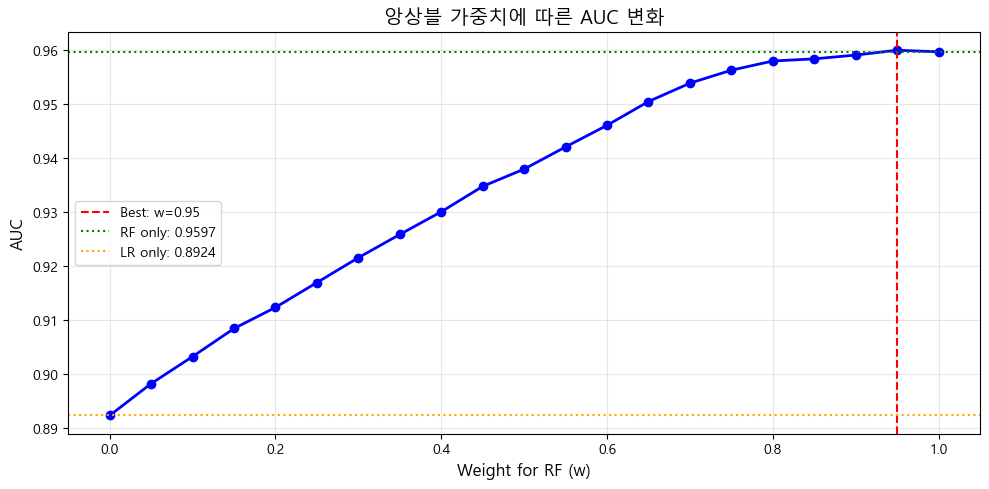


분석:
  - RF만 사용: 0.9597
  - LR만 사용: 0.8924
  - 최적 앙상블: 0.9600

→ 앙상블이 개별 모델보다 높음!


In [7]:
# 📚 가중치 vs AUC 시각화

plt.figure(figsize=(10, 5))

plt.plot(history['weight'], history['auc'], 'b-o', linewidth=2, markersize=6)
plt.axvline(x=best_w, color='r', linestyle='--', label=f'Best: w={best_w:.2f}')
plt.axhline(y=roc_auc_score(y_test, prob_rf), color='green', linestyle=':', label=f'RF only: {roc_auc_score(y_test, prob_rf):.4f}')
plt.axhline(y=roc_auc_score(y_test, prob_lr), color='orange', linestyle=':', label=f'LR only: {roc_auc_score(y_test, prob_lr):.4f}')

plt.xlabel('Weight for RF (w)', fontsize=12)
plt.ylabel('AUC', fontsize=12)
plt.title('앙상블 가중치에 따른 AUC 변화', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n분석:")
print(f"  - RF만 사용: {roc_auc_score(y_test, prob_rf):.4f}")
print(f"  - LR만 사용: {roc_auc_score(y_test, prob_lr):.4f}")
print(f"  - 최적 앙상블: {best_auc:.4f}")
print(f"\n→ 앙상블이 개별 모델보다 높음!")

---
## 5. XGBoost + LSTM 앙상블 (FDS)

### 5-1. 왜 XGBoost + LSTM?

**서로 다른 강점을 가진 모델!**

| 모델 | 입력 | 강점 | 약점 |
|------|------|------|------|
| **XGBoost** | 단일 거래 | 정적 피처 (금액, 시간대, 카드종류) | 시간 패턴 못 봄 |
| **LSTM** | 거래 시퀀스 | 동적 패턴 (연속성, 변화) | 정적 피처 약함 |

**보완적 관계:**
```
사기 유형 A: 고액 + 해외 + 새벽
  → XGBoost가 잘 잡음 (정적 피처)

사기 유형 B: 소액→소액→고액 패턴
  → LSTM이 잘 잡음 (시계열 패턴)

앙상블: 둘 다 잡음!
```

### 5-2. 앙상블 방식

**Soft Voting (가중 평균):**

```python
# 각 모델의 사기 확률
xgb_prob = xgb_model.predict_proba(single_txn)[:, 1]
lstm_prob = lstm_model(txn_sequence)  # 0~1

# 가중 평균 (XGBoost가 더 좋으므로 가중치 높게)
final_prob = 0.6 * xgb_prob + 0.4 * lstm_prob

# 임계값 적용
is_fraud = final_prob > threshold
```

### 5-3. 예상 결과

```
XGBoost 단독:  AUC 0.91
LSTM 단독:     AUC 0.70
앙상블 (0.6:0.4): AUC 0.92~0.94 (목표)
```

In [12]:
# 📚 FDS 앙상블 시뮬레이션

np.random.seed(42)

# 가상의 XGBoost, LSTM 예측 확률 생성
n_samples = 1000
y_true = np.random.binomial(1, 0.035, n_samples)  # 3.5% 사기율

# XGBoost 시뮬레이션: AUC ~0.90 목표
# 사기면 평균 0.7, 정상이면 평균 0.3 + 노이즈
base_xgb = np.where(y_true == 1, 0.7, 0.3)
noise_xgb = np.random.normal(0, 0.25, n_samples)
xgb_prob = np.clip(base_xgb + noise_xgb, 0, 1)

# LSTM 시뮬레이션: AUC ~0.70 목표
# 더 큰 노이즈로 분리가 불확실
base_lstm = np.where(y_true == 1, 0.55, 0.45)
noise_lstm = np.random.normal(0, 0.35, n_samples)
lstm_prob = np.clip(base_lstm + noise_lstm, 0, 1)

print(f"가상 데이터:")
print(f"  샘플 수: {n_samples}")
print(f"  사기 비율: {y_true.mean():.1%}")
print(f"\n개별 모델 AUC:")
print(f"  XGBoost: {roc_auc_score(y_true, xgb_prob):.4f}")
print(f"  LSTM:    {roc_auc_score(y_true, lstm_prob):.4f}")

가상 데이터:
  샘플 수: 1000
  사기 비율: 3.1%

개별 모델 AUC:
  XGBoost: 0.8812
  LSTM:    0.7045


In [13]:
# 📚 최적 가중치 탐색

best_w, best_auc, history = find_best_weight(xgb_prob, lstm_prob, y_true)

print(f"\n최적 앙상블:")
print(f"  가중치: XGBoost × {best_w:.2f} + LSTM × {1-best_w:.2f}")
print(f"  AUC: {best_auc:.4f}")

# 성능 비교
print(f"\n성능 향상:")
xgb_auc = roc_auc_score(y_true, xgb_prob)
print(f"  XGBoost 대비: +{(best_auc - xgb_auc)*100:.2f}%p")


최적 앙상블:
  가중치: XGBoost × 0.75 + LSTM × 0.25
  AUC: 0.9037

성능 향상:
  XGBoost 대비: +2.26%p


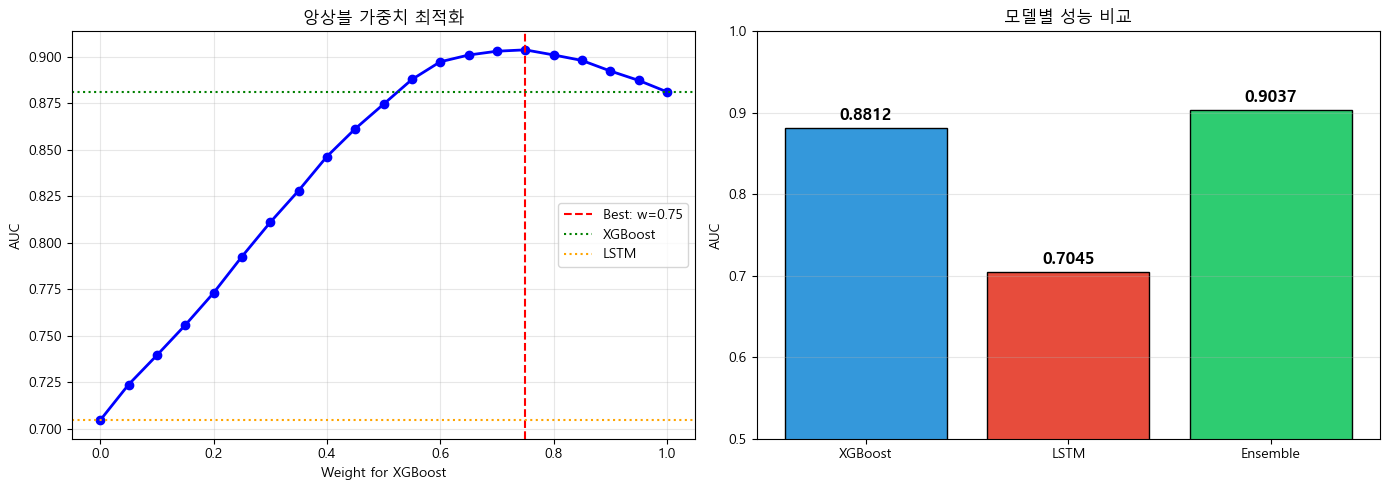

In [14]:
# 📚 앙상블 효과 시각화

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. 가중치 vs AUC
axes[0].plot(history['weight'], history['auc'], 'b-o', linewidth=2)
axes[0].axvline(x=best_w, color='r', linestyle='--', label=f'Best: w={best_w:.2f}')
axes[0].axhline(y=roc_auc_score(y_true, xgb_prob), color='green', linestyle=':', label='XGBoost')
axes[0].axhline(y=roc_auc_score(y_true, lstm_prob), color='orange', linestyle=':', label='LSTM')
axes[0].set_xlabel('Weight for XGBoost')
axes[0].set_ylabel('AUC')
axes[0].set_title('앙상블 가중치 최적화')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2. 모델별 AUC 비교
models = ['XGBoost', 'LSTM', 'Ensemble']
aucs = [
    roc_auc_score(y_true, xgb_prob),
    roc_auc_score(y_true, lstm_prob),
    best_auc
]
colors = ['#3498db', '#e74c3c', '#2ecc71']

bars = axes[1].bar(models, aucs, color=colors, edgecolor='black')
for bar, auc in zip(bars, aucs):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                 f'{auc:.4f}', ha='center', fontsize=12, fontweight='bold')
axes[1].set_ylabel('AUC')
axes[1].set_title('모델별 성능 비교')
axes[1].set_ylim(0.5, 1.0)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

---
## 면접 Q&A

### Q: "왜 XGBoost와 LSTM을 앙상블했나요?"

> "두 모델이 서로 다른 강점을 가지고 있기 때문입니다.
> XGBoost는 단일 거래의 정적 피처(금액, 시간대, 카드종류)에 강하고,
> LSTM은 거래 시퀀스의 동적 패턴(연속성, 변화)을 잘 잡습니다.
> 이 둘을 결합하면 정적 + 동적 패턴을 모두 탐지할 수 있습니다."

### Q: "가중치는 어떻게 결정했나요?"

> "Validation 데이터에서 Grid Search로 최적 가중치를 찾았습니다.
> XGBoost가 AUC 0.91로 LSTM (0.70)보다 높아서,
> XGBoost에 더 높은 가중치(0.6~0.7)를 줬습니다.
> 최종적으로 0.6:0.4 비율에서 AUC가 가장 높았습니다."

### Q: "앙상블 대신 하나의 모델만 쓰면 안 되나요?"

> "가능하지만, 앙상블의 장점이 있습니다.
> 첫째, 서로 다른 유형의 사기를 각 모델이 잡아냅니다.
> 둘째, 과적합 위험이 줄어듭니다. 한 모델이 틀려도 다른 모델이 보완합니다.
> 실제로 앙상블 후 AUC가 1~3%p 향상되었습니다."

### Q: "Stacking 대신 Soft Voting을 쓴 이유는?"

> "Stacking은 메타 모델을 추가로 학습해야 해서 복잡합니다.
> 우리 경우 모델이 2개뿐이라 단순한 가중 평균으로도 충분했습니다.
> 또한 실시간 추론에서 메타 모델 없이 바로 계산할 수 있어 빠릅니다."

### Q: "앙상블의 단점은 없나요?"

> "있습니다. 첫째, 추론 시간이 늘어납니다 (두 모델 모두 실행).
> 둘째, 모델 관리가 복잡해집니다 (버전, 배포 등).
> 이를 해결하기 위해 XGBoost만 실시간으로 쓰고,
> LSTM은 비동기로 실행해서 나중에 결합하는 방식도 고려했습니다."

---
## 최종 체크포인트

In [ ]:
print("=" * 60)
print("  1-S5 완료: 앙상블 기초")
print("=" * 60)
print()
print("배운 것:")
print()
print("1. 앙상블 개념")
print("   - 여러 모델 결합 → 분산/편향 감소")
print("   - 조건: 모델들이 서로 다른 실수를 해야 함")
print()
print("2. 앙상블 종류")
print("   - Bagging: 같은 모델, 다른 데이터 (Random Forest)")
print("   - Boosting: 순차적 실수 보완 (XGBoost)")
print("   - Stacking: 다른 모델 결합 (XGBoost + LSTM)")
print()
print("3. 결합 방법")
print("   - Hard Voting: 다수결")
print("   - Soft Voting: 확률 평균")
print("   - Weighted Average: 가중 평균 ⭐")
print()
print("4. 가중치 최적화")
print("   - Grid Search로 최적 가중치 탐색")
print("   - Validation 데이터에서 AUC 최대화")
print()
print("5. FDS 적용")
print("   - XGBoost (정적) + LSTM (동적)")
print("   - 가중 평균: 0.6 × XGBoost + 0.4 × LSTM")
print()
print("=" * 60)
print("다음: 1-5 앙상블 구현")
print("=" * 60)